In [32]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
wind = gpd.read_file('/Users/gzuckerm/Desktop/eagle_transfers/from_eagle/Supply_Curves/FY26/COMPASS/geospatial/Wind Ordinances reVX 2025-09-12.gpkg').to_crs(5070)
solar = gpd.read_file('/Users/gzuckerm/Desktop/eagle_transfers/from_eagle/Supply_Curves/FY26/COMPASS/geospatial/Solar Ordinances reVX 2025-12-30.gpkg').to_crs(5070)

us_sub = gpd.read_file('/Users/gzuckerm/Desktop/eagle_transfers/from_eagle/Supply_Curves/FY26/COMPASS/geospatial/cb_2024_us_cousub_500k/cb_2024_us_cousub_500k.shp').to_crs(5070)

In [3]:
uswtdb = gpd.read_file("/Users/gzuckerm/Desktop/eagle_transfers/from_eagle/Supply_Curves/FY26/COMPASS/spread/uswtdbSHP-4/uswtdb_V8_2_20251210.shp").to_crs(5070)
uspvdb = gpd.read_file('/Users/gzuckerm/Desktop/eagle_transfers/from_eagle/Supply_Curves/FY26/COMPASS/spread/uspvdbSHP/uspvdb_v3_0_20250430.shp').to_crs(5070)

In [4]:
uswtdb = uswtdb[uswtdb['p_cap']>0]
uswtdb = uswtdb[uswtdb['p_year']>0]
uspvdb = uspvdb[uspvdb['p_cap_ac']>0]
uspvdb = uspvdb[uspvdb['p_year']>0]

In [5]:
# Group uswtdb by plant name and year, aggregating capacity and creating centroid geometry

# Wind plant summary
wind_plant_summary = uswtdb.groupby(['p_name', 'p_year']).agg({
    'p_cap': 'sum',
    'case_id': 'count',
    't_state': 'first',
    't_county': 'first',
    'geometry': lambda x: x.unary_union.centroid
}).reset_index()

wind_plant_summary.columns = ['Plant_Name', 'Year', 'Total_Capacity_MW', 'Turbine_Count', 'State', 'County', 'geometry']
wind_plant_summary['Total_Capacity_GW'] = wind_plant_summary['Total_Capacity_MW'] / 1000
wind_plant_summary = gpd.GeoDataFrame(wind_plant_summary, geometry='geometry', crs=uswtdb.crs)
wind_plant_summary = wind_plant_summary.sort_values(['Year', 'Total_Capacity_GW'], ascending=[True, False])

# Solar plant summary
solar_plant_summary = uspvdb.groupby(['p_name', 'p_year']).agg({
    'p_cap_ac': 'sum',
    'case_id': 'count',
    'p_state': 'first',
    'p_county': 'first',
    'geometry': lambda x: x.unary_union.centroid
}).reset_index()

solar_plant_summary.columns = ['Plant_Name', 'Year', 'Total_Capacity_MW', 'Panel_Count', 'State', 'County', 'geometry']
solar_plant_summary['Total_Capacity_GW'] = solar_plant_summary['Total_Capacity_MW'] / 1000
solar_plant_summary = gpd.GeoDataFrame(solar_plant_summary, geometry='geometry', crs=uspvdb.crs)
solar_plant_summary = solar_plant_summary.sort_values(['Year', 'Total_Capacity_GW'], ascending=[True, False])

print("Wind Plant Summary:")
print(wind_plant_summary.head(20))
print(f"\nSolar Plant Summary:")
print(solar_plant_summary.head(20))


Wind Plant Summary:
                                         Plant_Name  Year  Total_Capacity_MW  \
650           Historic Victory Garden (Wind Stream)  1982           3587.000   
1053                       Oak Creek Energy Systems  1982             19.692   
1464                          Tehachapi Windplant I  1984           1167.140   
1287                   San Gorgonio Farms Wind Farm  1984            651.000   
1233                                       Ridgetop  1985           3132.000   
34                                       Altech III  1985            108.540   
597                               H & S - Tehachapi  1985             57.330   
1113                                 Patterson Wind  1985             36.400   
425                                      East Winds  1985             29.155   
1288                   San Gorgonio Farms Wind Farm  1985             28.470   
1112                                 Patterson Pass  1985             13.065   
1289                

In [6]:
# Group uswtdb by county and year to summarize wind capacity growth
wind_growth = uswtdb.groupby(['t_county', 'p_year'])['p_cap'].sum().reset_index()
wind_growth.columns = ['County', 'Year', 'Capacity_GW']

# Convert capacity from MW to GW
wind_growth['Capacity_GW'] = wind_growth['Capacity_GW'] / 1000

# Add state name by merging with uswtdb
wind_growth = wind_growth.merge(
    uswtdb[['t_county', 't_state']].drop_duplicates(),
    left_on='County',
    right_on='t_county',
    how='left'
).drop('t_county', axis=1)

# Rename state column
wind_growth.rename(columns={'t_state': 'State'}, inplace=True)

# Reorder columns
wind_growth = wind_growth[['State', 'County', 'Year', 'Capacity_GW']]

# Sort by state, county, and year
wind_growth = wind_growth.sort_values(['State', 'County', 'Year'])

# Calculate cumulative capacity by county
wind_growth['Cumulative_Capacity_GW'] = wind_growth.groupby('County')['Capacity_GW'].cumsum()

wind_growth.head(20)

,State,County,Year,Capacity_GW,Cumulative_Capacity_GW
81,AK,Aleutians East Borough,2012,0.002000,0.002000
82,AK,Aleutians West Census Area,1999,0.000225,0.000225
83,AK,Aleutians West Census Area,2007,0.001350,0.001575
176,AK,Bethel Census Area,2006,0.000900,0.000900
177,AK,Bethel Census Area,2010,0.002500,0.003400
178,AK,Bethel Census Area,2012,0.002375,0.005775
179,AK,Bethel Census Area,2018,0.000900,0.006675
518,AK,Denali Borough,2012,0.295200,0.295200
1081,AK,Kenai Peninsula Borough,2001,0.024000,0.024000
1082,AK,Kenai Peninsula Borough,2012,0.017600,0.041600


In [7]:
# Filter to CONUS (exclude Alaska, Hawaii, and territories)
# State FIPS codes for non-CONUS states
non_conus_fips = ['02', '15', '60', '66', '69', '72', '78']  # AK, HI, AS, GU, MP, PR, VI
non_conus_states = ['Alaska', 'Hawaii', 'Puerto Rico', 'American Samoa', 
                    'Guam', 'Northern Mariana Islands', 'U.S. Virgin Islands']

# Filter us_sub to CONUS using STATEFP
us_sub_conus = us_sub[~us_sub['STATEFP'].isin(non_conus_fips)].copy()

# Filter wind and solar datasets to CONUS using state name
wind_conus = wind[~wind['State'].isin(non_conus_states)].copy()
solar_conus = solar[~solar['State'].isin(non_conus_states)].copy()

wind_conus = wind_conus[wind_conus['Ordinance Year'].isna()==False]
solar_conus = solar_conus[solar_conus['Ordinance Year'].isna()==False]


print(f"Original us_sub records: {len(us_sub):,}")
print(f"CONUS us_sub records: {len(us_sub_conus):,}")
print(f"\nOriginal wind records: {len(wind):,}")
print(f"CONUS wind records: {len(wind_conus):,}")
print(f"\nOriginal solar records: {len(solar):,}")
print(f"CONUS solar records: {len(solar_conus):,}")

Original us_sub records: 36,354
CONUS us_sub records: 35,309

Original wind records: 12,238
CONUS wind records: 7,115

Original solar records: 11,437
CONUS solar records: 6,320


In [8]:
# Check feature types in wind ordinances
print("Wind ordinance feature types:")
print(wind_conus['Feature Type'].value_counts())
print(f"\nMost common feature type: {wind_conus['Feature Type'].value_counts().index[0]}")

Wind ordinance feature types:
Feature Type
Property Line                    608
Decommissioning                  558
Roads                            515
Structures                       514
Special Use Districts            457
Color                            447
Sound                            433
Lighting                         429
Climbing Prevention              407
Signage                          376
Blade Clearance                  319
Transmission                     302
Maximum Height                   283
Visual Impact                    234
Soil                             205
Shadow Flicker                   192
Prohibitions                     120
Structures (participating)       107
Water                            106
Primary Use Districts             89
Railroads                         77
Minimum Lot Size                  76
Tower Density                     70
Accessory Use Districts           61
Maximum Installation Size         57
Property Line (participating)   

In [34]:
def map_ordinances_by_year(ordinance_type, technology='wind'):
    """
    Create a map of ordinances by year for a given feature type and technology.
    Also plots plant-level data sized by capacity and colored by year.
    
    Parameters:
    -----------
    ordinance_type : str
        The feature type to map (e.g., 'Property Line', 'Decommissioning', etc.)
    technology : str, default='wind'
        The technology type: 'wind' or 'solar'
    """
    # Select the appropriate datasets
    if technology.lower() == 'wind':
        data = wind_conus
        plant_data = wind_plant_summary.copy()
    elif technology.lower() == 'solar':
        data = solar_conus
        plant_data = solar_plant_summary.copy()
    else:
        raise ValueError("technology must be 'wind' or 'solar'")
    
    # Filter to the specified ordinance type
    filtered_data = data[data['Feature Type'] == ordinance_type].copy()
    filtered_data['Ordinance Year'] = pd.to_numeric(filtered_data['Ordinance Year'], errors='coerce')

    
    if len(filtered_data) == 0:
        print(f"Warning: No ordinances found for {ordinance_type} in {technology} dataset")
        return
    
     # Set all plant years before 2000 to 2000 (instead of filtering them out)
    plant_data_filtered = plant_data.copy()
    plant_data_filtered['Year'] = plant_data_filtered['Year'].apply(lambda x: max(x, 2000))
    
    # Create the map
    fig, ax = plt.subplots(figsize=(20, 12))
    
    # Get CONUS bounds and set them explicitly
    bounds = us_sub_conus.total_bounds
    padding = 0.02  # 2% padding
    x_range = bounds[2] - bounds[0]
    y_range = bounds[3] - bounds[1]
    
    # Set axis limits with padding BEFORE plotting
    ax.set_xlim(bounds[0] - padding * x_range, bounds[2] + padding * x_range)
    ax.set_ylim(bounds[1] - padding * y_range, bounds[3] + padding * y_range)
    
    # Plot subdivisions as base layer with increased visibility
    us_sub_conus.plot(ax=ax, color='lightgray', edgecolor='darkgray', linewidth=0.2, alpha=0.5)
    
    # Plot plant data sized by capacity and colored by year
    # Scale marker sizes (convert GW to reasonable point sizes)
    plant_sizes = plant_data_filtered['Total_Capacity_GW'] * 1  # Scale factor for visibility - reduced from 100

    
    
    # Plot ordinances colored by year (beneath plants)
    filtered_data.plot(
        ax=ax, 
        column='Ordinance Year',
        cmap='viridis',
        legend=False,
        markersize=10,
        alpha=0.7,
        vmin=2000,
        vmax=2025
    )

    plant_data_filtered.plot(
        ax=ax,
        column='Year',
        cmap='viridis',
        markersize=plant_sizes,
        alpha=0.4,
        legend=False,
        vmin=2000,
        vmax=2025,
        edgecolor='black',
        linewidth=0.3
    )
    
    # Add a continuous colorbar
    sm = plt.cm.ScalarMappable(cmap='viridis', 
                               norm=plt.Normalize(vmin=2000, 
                                                 vmax=2025))
    sm._A = []
    cbar = fig.colorbar(sm, ax=ax, shrink=0.6)
    cbar.set_label('Year', fontsize=12)
    
  
    # Add size legend for plant capacity
    # Create legend elements for different capacity sizes
    capacity_sizes = [0.1, 0.5, 1.0, 2.0, 5.0]  # GW
    legend_elements = []
    for cap in capacity_sizes:
        legend_elements.append(
            plt.Line2D([0], [0], marker='o', color='w', 
                      markerfacecolor='gray', markersize=np.sqrt(cap * 1),  # Match the scaling used in plant_sizes
                      alpha=0.6, markeredgecolor='black', markeredgewidth=0.5,
                      label=f'{cap} GW')
        )
    
    # Add the legend to the plot
    leg = ax.legend(handles=legend_elements, 
                   title=f'{technology.title()} Plant Capacity',
                   loc='lower left',
                   frameon=True,
                   framealpha=0.9,
                   fontsize=10,
                   title_fontsize=11)

    # ax.set_title(f'{technology.title()} Ordinances: {ordinance_type} by Year (n={len(filtered_data):,})\n' + 
    #              f'with {technology.title()} Plants (sized by capacity, n={len(plant_data_filtered):,})', 
    #              fontsize=16, fontweight='bold')


    ax.set_title(f'{technology.title()} Ordinances: {ordinance_type} by Year (n={len(filtered_data):,})',
                 fontsize=16, fontweight='bold')


    ax.axis('off')
    ax.set_aspect('equal')
    
    plt.tight_layout()
    plt.show()

    return filtered_data

In [16]:
# Get top 5 most common ordinance types for wind
print("Top 5 Wind Ordinance Types:")
top_5_wind = wind_conus['Feature Type'].value_counts().head(5)
print(top_5_wind)
print("\n" + "="*60 + "\n")

# Get top 5 most common ordinance types for solar
print("Top 5 Solar Ordinance Types:")
top_5_solar = solar_conus['Feature Type'].value_counts().head(5)
print(top_5_solar)

Top 5 Wind Ordinance Types:
Feature Type
Property Line            608
Decommissioning          558
Roads                    515
Structures               514
Special Use Districts    457
Name: count, dtype: int64


Top 5 Solar Ordinance Types:
Feature Type
Decommissioning          598
Screening                560
Property Line            532
Fencing                  501
Special Use Districts    482
Name: count, dtype: int64


## Wind Ordinances - Top 5 Feature Types

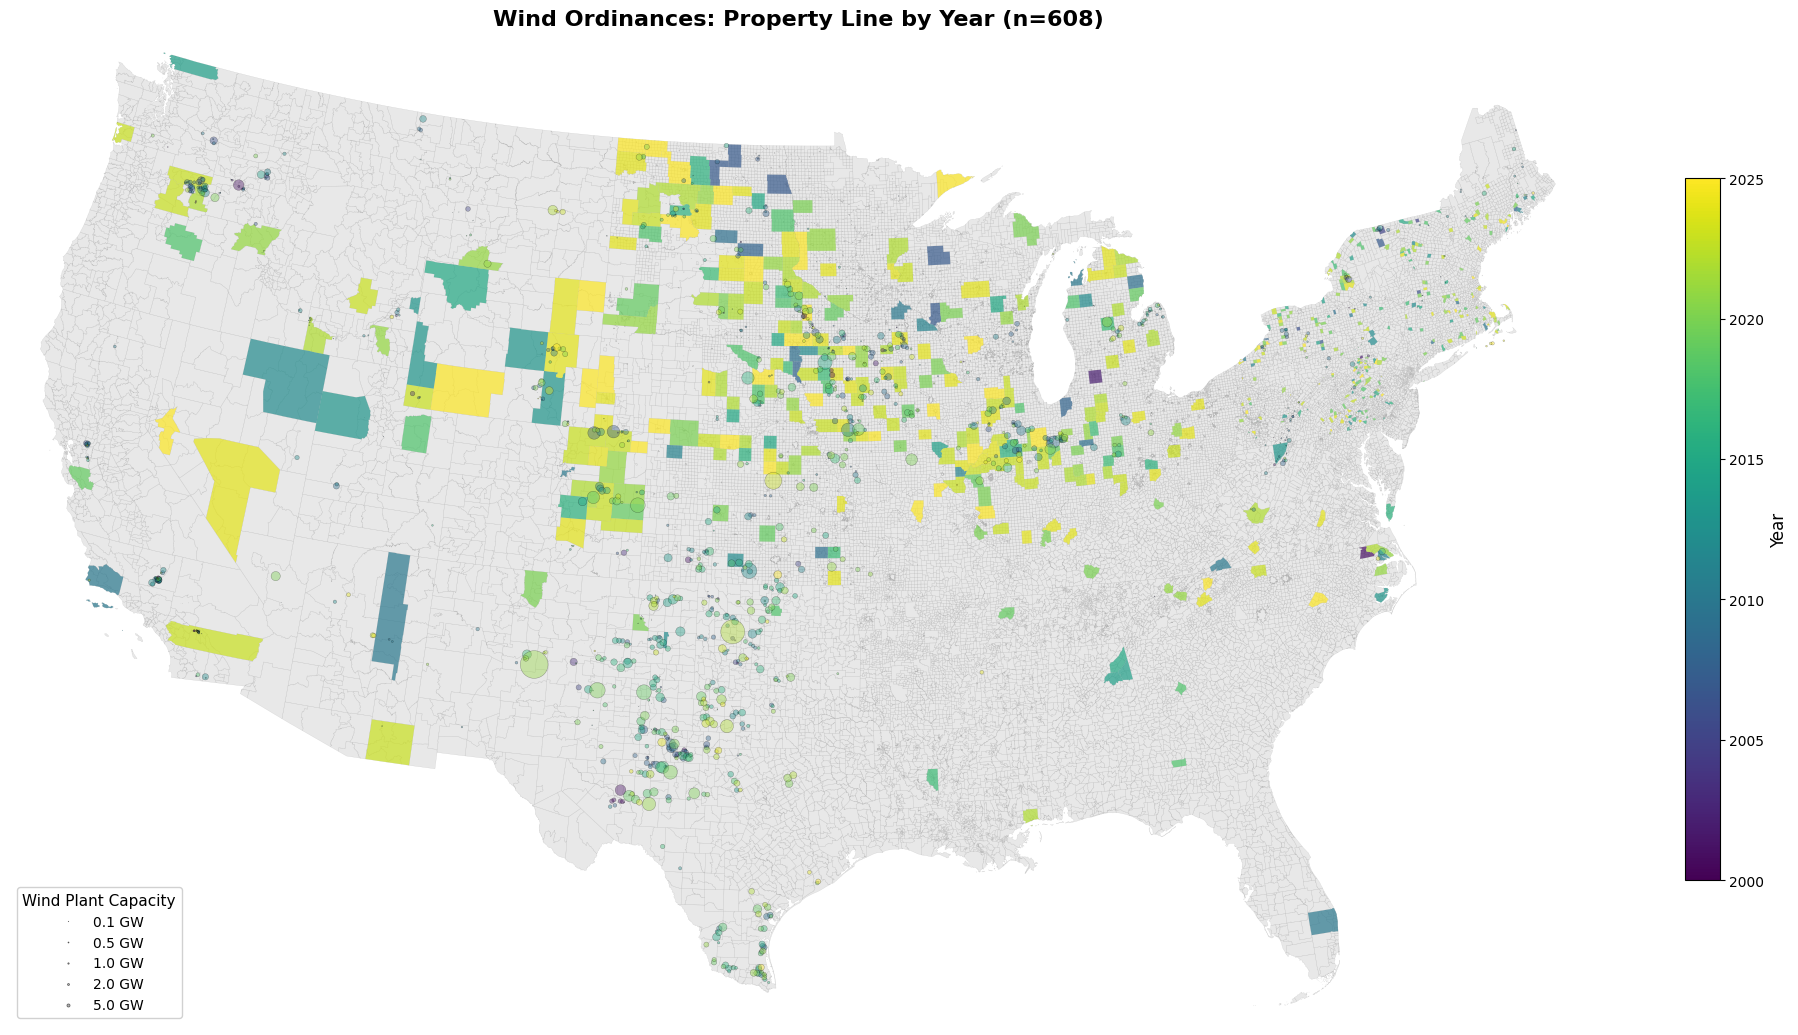

,State,County,Subdivision,Jurisdiction Type,FIPS,Feature Type,Feature Subtype,Value,Value Type,Setback Adder,Minimum Setback Distance,Maximum Setback Distance,Summary,Section,Ordinance Year,Source URL,geometry
10,Illinois,Warren,NaN,County,17187,Property Line,NaN,1.1,Max-tip Height Multiplier,NaN,NaN,NaN,"A large wind system, excluding transmission li...",§ 150.302 STANDARDS,2022,https://warrencountyil.gov/wp-content/uploads/...,"MULTIPOLYGON (((436783.264 1970299.433, 436755..."
38,Alabama,Etowah,NaN,County,1055,Property Line,NaN,762.0,meters,NaN,NaN,NaN,A wind energy conversion system may not encroa...,Section 6,2014,https://alison.legislature.state.al.us/files/p...,"MULTIPOLYGON (((882200.501 1253142.008, 882326..."
63,California,Santa Clara,NaN,County,6085,Property Line,NaN,1.5,Max-tip Height Multiplier,NaN,NaN,NaN,Wind energy conversion systems shall be set ba...,§ 4.10.390 Wind Energy Conversion Systems ...,2019,https://farmlandinfo.org/wp-content/uploads/si...,"MULTIPOLYGON (((-2269807.348 1906352.443, -226..."
84,Idaho,Butte,NaN,County,16023,Property Line,NaN,1.0,Max-tip Height Multiplier,NaN,NaN,NaN,The minimum required setback distance between ...,4. ADDITIONAL STANDARDS: USE PERMIT CRITERIA,2023,https://buttecountyid.us/wp-content/uploads/20...,"MULTIPOLYGON (((-1422935.934 2420205.049, -142..."
91,Iowa,Union,NaN,County,19175,Property Line,NaN,7.0,Max-tip Height Multiplier,NaN,3281.0,NaN,Each Wind Turbine shall be set back a distance...,SECTION 4. GENERAL REQUIREMENTS FOR C-WECS AND...,2024,https://unioncountyiowa.gov/wp-content/uploads...,"MULTIPOLYGON (((127493.804 2005284.689, 127496..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12179,Pennsylvania,Cumberland,Dickinson,Township,4204119144,Property Line,NaN,1.5,Max-tip Height Multiplier,NaN,50.0,NaN,Wind turbines shall be setback from adjoining ...,490.D.13.,2023,https://ecode360.com/DI2023/laws/LF1197876.pdf,"MULTIPOLYGON (((1572720.733 2063977.651, 15729..."
12193,Pennsylvania,Luzerne,Dallas,Borough,4207918048,Property Line,NaN,1.1,Max-tip Height Multiplier,NaN,NaN,NaN,All wind turbines shall be set back from the n...,708 Wind Energy Facility (Non-Personal) (I...,2009,https://dallasborough.org/wp-content/uploads/2...,"MULTIPOLYGON (((1651076.328 2208914.996, 16491..."
12205,Pennsylvania,Luzerne,Harveys Lake,Borough,4207933000,Property Line,NaN,457.20000000000005,meters,NaN,1500.0,NaN,The minimum setback distance for each wind tur...,SECTION 708 D. SETBACKS,2021,https://img1.wsimg.com/blobby/go/2395f50b-2431...,"MULTIPOLYGON (((1642507.330 2214728.546, 16442..."
12221,Pennsylvania,Lycoming,Fairfield,Township,4208124592,Property Line,NaN,1.1,Max-tip Height Multiplier,NaN,NaN,NaN,All Wind Turbines shall be set back from the n...,12.19.5 Setbacks,2020,https://fairfieldlycoming.org/wp-content/uploa...,"MULTIPOLYGON (((1575566.807 2189401.978, 15794..."


In [35]:
map_ordinances_by_year('Property Line', technology='wind')

In [ ]:
# Map top 5 wind ordinance types
for ordinance_type in top_5_wind.index:
    print(f"\n{'='*80}")
    print(f"Mapping: {ordinance_type}")
    print('='*80)
    map_ordinances_by_year(ordinance_type, technology='wind')


Mapping: P

Mapping: r

Mapping: o

Mapping: p

Mapping: e

Mapping: r

Mapping: t

Mapping: y

Mapping:  

Mapping: L

Mapping: i

Mapping: n

Mapping: e


## Solar Ordinances - Top 5 Feature Types

In [ ]:
# Map top 5 solar ordinance types
for ordinance_type in top_5_solar.index:
    print(f"\n{'='*80}")
    print(f"Mapping: {ordinance_type}")
    print('='*80)
    map_ordinances_by_year(ordinance_type, technology='solar')